# Assignment 9: GBDT

#### Response Coding: Example

<img src='http://i.imgur.com/TufZptV.jpg' width=700px>

> The response tabel is built only on train dataset.
> For a category which is not there in train data and present in test data, we will encode them with default values
Ex: in our test data if have State: D then we encode it as [0.5, 0.05]

<ol>
    <li><strong>Apply GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF)+  preprocessed_eassay (TFIDF)+sentiment Score of eassay(check the bellow example, include all 4 values as 4 features)</li>
            <li><font color='red'>Set 2</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF W2V)+  preprocessed_eassay (TFIDF W2V)</li>        </ul>
    </li>
    <li><strong>The hyper paramter tuning (Consider any two hyper parameters)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation/simple cross validation data</li>
    <li>use gridsearch cv or randomsearch cv or you can write your own for loops to do this task</li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/Gp2DQmh.jpg' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/fgN9aUP.jpg' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
            </ul>
    <br>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install xgboost

In [4]:
!pip install plotly --upgrade

     |████████████████████████████████| 13.1MB 239kB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [5]:
path = '/content/drive/My Drive/AAIC/ASSIGN_13/11_Donors_choose_GBDT/'

# Task 1

### 1.1 Loading Data

In [6]:
import pandas
data = pandas.read_csv(path+'preprocessed_data.csv',nrows=50000)

In [7]:
data.head(1)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05


In [8]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import re
from tqdm import tqdm

#### 1.1.0 Adding Sentiment analysis features such as NEG, POS, NEU and COMPOUND polarity scores 

In [9]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
NEG = []
NEU = []
POS = []
COMP = []
essays = data['essay'].values
for senetence in essays:
  ss = sid.polarity_scores(senetence)
  NEG.append(ss['neg'])
  POS.append(ss['pos'])
  NEU.append(ss['neu'])
  COMP.append(ss['compound'])

df2 = pd.DataFrame({'NEG':NEG,
                    'POS':POS,
                    'NEU':NEU,
                    'COMPOUND':COMP})


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [10]:
df2.head(2)

,NEG,POS,NEU,COMPOUND
0,0.013,0.205,0.783,0.9867
1,0.072,0.248,0.680,0.9897


In [11]:
data = pd.concat([data, df2], axis=1)
data.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price,NEG,POS,NEU,COMPOUND
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05,0.013,0.205,0.783,0.9867
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03,0.072,0.248,0.680,0.9897


#### 1.1.1 Processing Project Essay.

In [12]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [13]:
#https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [14]:
# Combining all the above stundents 
from tqdm import tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [15]:
data.essay.iloc[:1]

0    i fortunate enough use fairy tale stem kits cl...
Name: essay, dtype: object

As there are some stop words present in the text of essay of already preprocessed_data. For example word ` **i** ' is present in the first essay sentence. So, I am processing the essay text again inorder to remove the stop words if there are any by chance and also because  unnecessary stop words increase the dimensionality of the bow/tfidf representation.

In [16]:
data['essay'] = preprocess_text(data['essay'].values)

100%|██████████| 50000/50000 [00:20<00:00, 2484.92it/s]


In [17]:
data.essay.iloc[:1]

0    fortunate enough use fairy tale stem kits clas...
Name: essay, dtype: object

In [18]:
data.head(1)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price,NEG,POS,NEU,COMPOUND
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,fortunate enough use fairy tale stem kits clas...,725.05,0.013,0.205,0.783,0.9867


#### 1.1.2 Loading data after processing  essay 

In [19]:
Y=data['project_is_approved']       
X=data.drop('project_is_approved',axis=1)

In [20]:
X.head(1)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price,NEG,POS,NEU,COMPOUND
0,ca,mrs,grades_prek_2,53,math_science,appliedsciences health_lifescience,fortunate enough use fairy tale stem kits clas...,725.05,0.013,0.205,0.783,0.9867


### 1.2 Splitting data into Train and cross validation(or test): Stratified Sampling

In [21]:
from sklearn.model_selection import train_test_split

X_train,X_te,Y_train,Y_te = train_test_split(X,Y,test_size=0.33, stratify=Y, random_state=10)

In [22]:
print(X_train.shape,Y_train.shape,X_te.shape,Y_te.shape,end=" ")

(33500, 12) (33500,) (16500, 12) (16500,) 

### 1.3 Make Data Model Ready: encoding project essay

### 1.3.1 TFIDF Representation of essay.

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4))
vectorizer.fit(X_train['essay'].values)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=10, ngram_range=(1, 4), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [24]:

essay_tr_tfidf = vectorizer.transform(X_train['essay'].values)
essay_te_tfidf = vectorizer.transform(X_te['essay'].values)


In [25]:
print(essay_tr_tfidf.shape,essay_te_tfidf.shape,end=" ")

(33500, 99859) (16500, 99859) 

### 1.3.2 TFIDF-W2V Representation of essay.

In [26]:
import pickle
with open(path+'glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [27]:
# average Word2Vec
# compute average word2vec for each review.
def tfidf_w2v_transform(preprocessed_essays):
  tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
  for sentence in tqdm(preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors.append(vector)

  return tfidf_w2v_vectors


##### Train data

In [28]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer(min_df=10,ngram_range=(1,4))
tfidf_model.fit(X_train['essay'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [29]:
essay_tr_tfidf_w2v = np.array(tfidf_w2v_transform(X_train['essay']))
essay_te_tfidf_w2v = np.array(tfidf_w2v_transform(X_te['essay']))
#print(preprocessed_essays[:3])

100%|██████████| 16500/16500 [00:32<00:00, 508.49it/s]


In [30]:
print(essay_tr_tfidf_w2v.shape,essay_te_tfidf_w2v.shape,end=" ")

(33500, 300) (16500, 300) 

<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

### 1.3.3 Encoding Categorical features
  

In [31]:
data.columns

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price', 'NEG',
       'POS', 'NEU', 'COMPOUND'],
      dtype='object')

##### School State

In [32]:
df = pd.DataFrame({'ftr' : X_train['school_state'], 'label' : Y_train})
sam_df = pd.DataFrame(columns = ['prob_0', 'prob_1'],index =  set(df['ftr']) )
for i in set(df['ftr']):
  sam_df.loc[i].prob_0 = len(df[(df['ftr'] == (i)) & (df['label'] == 0)])/ len(df[df['ftr'] == (i)])
  sam_df.loc[i].prob_1 = len(df[(df['ftr'] == (i)) & (df['label'] == 1)])/ len(df[df['ftr'] == (i)])

In [33]:
cat_data_tr = pd.DataFrame(columns= ['prob_0','prob_1'],index = df.index)
for i in list(df.index.values):
  j = df.loc[i][['ftr']].values
  #print(j[0])
  cat_data_tr.loc[i] = {'prob_0':sam_df.loc[j[0]].prob_0 , 'prob_1':sam_df.loc[j[0]].prob_1}
cat_data_tr= cat_data_tr.values
print(cat_data_tr.shape)

(33500, 2)


In [34]:
df3 = X_te['school_state']
cat_data_te = pd.DataFrame(columns= ['prob_0','prob_1'],index = df3.index)
for i in (df3.index):
  if df3.loc[i] not in sam_df.index:
    cat_data_te.loc[i] = {'prob_0':0.5 , 'prob_1':0.5}
  else:
    cat_data_te.loc[i] = {'prob_0':sam_df.loc[df3.loc[i]].prob_0 , 'prob_1':sam_df.loc[df3.loc[i]].prob_1}
cat_data_te = cat_data_te.values

In [35]:
state_tr = cat_data_tr
state_te = cat_data_te

In [36]:
print(state_tr.shape,state_te.shape,end=" ")

(33500, 2) (16500, 2) 

#### Teacher prefix

In [37]:
df = pd.DataFrame({'ftr' : X_train['teacher_prefix'], 'label' : Y_train})
sam_df = pd.DataFrame(columns = ['prob_0', 'prob_1'],index =  set(df['ftr']) )
for i in set(df['ftr']):
  sam_df.loc[i].prob_0 = len(df[(df['ftr'] == (i)) & (df['label'] == 0)])/ len(df[df['ftr'] == (i)])
  sam_df.loc[i].prob_1 = len(df[(df['ftr'] == (i)) & (df['label'] == 1)])/ len(df[df['ftr'] == (i)])

In [38]:
cat_data_tr = pd.DataFrame(columns= ['prob_0','prob_1'],index = df.index)
for i in list(df.index.values):
  j = df.loc[i][['ftr']].values
  #print(j[0])
  cat_data_tr.loc[i] = {'prob_0':sam_df.loc[j[0]].prob_0 , 'prob_1':sam_df.loc[j[0]].prob_1}
cat_data_tr= cat_data_tr.values
print(cat_data_tr.shape)

(33500, 2)


In [39]:
df3 = X_te['teacher_prefix']
cat_data_te = pd.DataFrame(columns= ['prob_0','prob_1'],index = df3.index)
for i in (df3.index):
  if df3.loc[i] not in sam_df.index:
    cat_data_te.loc[i] = {'prob_0':0.5 , 'prob_1':0.5}
  else:
    cat_data_te.loc[i] = {'prob_0':sam_df.loc[df3.loc[i]].prob_0 , 'prob_1':sam_df.loc[df3.loc[i]].prob_1}
cat_data_te = cat_data_te.values

In [40]:
tchr_prefix_tr = cat_data_tr
tchr_prefix_te = cat_data_te

In [41]:
print(tchr_prefix_tr.shape,tchr_prefix_te.shape,end=" ")

(33500, 2) (16500, 2) 

#### Project grade_category

In [42]:
df = pd.DataFrame({'ftr' : X_train['project_grade_category'], 'label' : Y_train})
sam_df = pd.DataFrame(columns = ['prob_0', 'prob_1'],index =  set(df['ftr']) )
for i in set(df['ftr']):
  sam_df.loc[i].prob_0 = len(df[(df['ftr'] == (i)) & (df['label'] == 0)])/ len(df[df['ftr'] == (i)])
  sam_df.loc[i].prob_1 = len(df[(df['ftr'] == (i)) & (df['label'] == 1)])/ len(df[df['ftr'] == (i)])

In [43]:
cat_data_tr = pd.DataFrame(columns= ['prob_0','prob_1'],index = df.index)
for i in list(df.index.values):
  j = df.loc[i][['ftr']].values
  #print(j[0])
  cat_data_tr.loc[i] = {'prob_0':sam_df.loc[j[0]].prob_0 , 'prob_1':sam_df.loc[j[0]].prob_1}
cat_data_tr= cat_data_tr.values
print(cat_data_tr.shape)

(33500, 2)


In [44]:
df3 = X_te['project_grade_category']
cat_data_te = pd.DataFrame(columns= ['prob_0','prob_1'],index = df3.index)
for i in (df3.index):
  if df3.loc[i] not in sam_df.index:
    cat_data_te.loc[i] = {'prob_0':0.5 , 'prob_1':0.5}
  else:
    cat_data_te.loc[i] = {'prob_0':sam_df.loc[df3.loc[i]].prob_0 , 'prob_1':sam_df.loc[df3.loc[i]].prob_1}
cat_data_te = cat_data_te.values

In [45]:
grade_tr = cat_data_tr
grade_te = cat_data_te

In [46]:
print(grade_tr.shape,grade_te.shape,end=" ")

(33500, 2) (16500, 2) 

#### Subject categories

In [47]:
df = pd.DataFrame({'ftr' : X_train['clean_categories'], 'label' : Y_train})
sam_df = pd.DataFrame(columns = ['prob_0', 'prob_1'],index =  set(df['ftr']) )
for i in set(df['ftr']):
  sam_df.loc[i].prob_0 = len(df[(df['ftr'] == (i)) & (df['label'] == 0)])/ len(df[df['ftr'] == (i)])
  sam_df.loc[i].prob_1 = len(df[(df['ftr'] == (i)) & (df['label'] == 1)])/ len(df[df['ftr'] == (i)])

In [48]:
cat_data_tr = pd.DataFrame(columns= ['prob_0','prob_1'],index = df.index)
for i in list(df.index.values):
  j = df.loc[i][['ftr']].values
  #print(j[0])
  cat_data_tr.loc[i] = {'prob_0':sam_df.loc[j[0]].prob_0 , 'prob_1':sam_df.loc[j[0]].prob_1}
cat_data_tr= cat_data_tr.values
print(cat_data_tr.shape)

(33500, 2)


In [49]:
df3 = X_te['clean_categories']
cat_data_te = pd.DataFrame(columns= ['prob_0','prob_1'],index = df3.index)
for i in (df3.index):
  if df3.loc[i] not in sam_df.index:
    cat_data_te.loc[i] = {'prob_0':0.5 , 'prob_1':0.5}
  else:
    cat_data_te.loc[i] = {'prob_0':sam_df.loc[df3.loc[i]].prob_0 , 'prob_1':sam_df.loc[df3.loc[i]].prob_1}
cat_data_te = cat_data_te.values

In [50]:
subject_tr = cat_data_tr
subject_te = cat_data_te

In [51]:
print(subject_tr.shape,subject_te.shape,end=" ")

(33500, 2) (16500, 2) 

#### Subject sub categories

In [52]:
df = pd.DataFrame({'ftr' : X_train['clean_subcategories'], 'label' : Y_train})
sam_df = pd.DataFrame(columns = ['prob_0', 'prob_1'],index =  set(df['ftr']) )
for i in set(df['ftr']):
  sam_df.loc[i].prob_0 = len(df[(df['ftr'] == (i)) & (df['label'] == 0)])/ len(df[df['ftr'] == (i)])
  sam_df.loc[i].prob_1 = len(df[(df['ftr'] == (i)) & (df['label'] == 1)])/ len(df[df['ftr'] == (i)])

In [53]:
print(df.shape,sam_df.shape)

(33500, 2) (342, 2)


In [54]:
cat_data_tr = pd.DataFrame(columns= ['prob_0','prob_1'],index = df.index)
for i in list(df.index.values):
  j = df.loc[i][['ftr']].values
  #print(j[0])
  cat_data_tr.loc[i] = {'prob_0':sam_df.loc[j[0]].prob_0 , 'prob_1':sam_df.loc[j[0]].prob_1}
cat_data_tr= cat_data_tr.values
print(cat_data_tr.shape)

(33500, 2)


In [55]:
df3 = X_te['clean_subcategories']
cat_data_te = pd.DataFrame(columns= ['prob_0','prob_1'],index = df3.index)
for i in (df3.index):
  if df3.loc[i] not in sam_df.index:
    cat_data_te.loc[i] = {'prob_0':0.5 , 'prob_1':0.5}
  else:
    cat_data_te.loc[i] = {'prob_0':sam_df.loc[df3.loc[i]].prob_0 , 'prob_1':sam_df.loc[df3.loc[i]].prob_1}
cat_data_te = cat_data_te.values

In [56]:
print(df3.shape,cat_data_te.shape)

(16500,) (16500, 2)


In [57]:
subj_subct_tr = cat_data_tr
subj_subct_te = cat_data_te

In [58]:
print(subj_subct_tr.shape,subj_subct_te.shape,end=" ")

(33500, 2) (16500, 2) 

### 1.3.4  Encoding Numerical features

#### teacher_number_of_previously_posted_projects

In [59]:
#For z-score normalization the values will be both negative and positive. MultinomialNB does not work with negative values. 
#So we use Min-Max normalization. 
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

tchr_prj_tr = scaler.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
tchr_prj_te = scaler.transform(X_te['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

In [60]:
print(list(tchr_prj_tr[:5]),'\n',list(tchr_prj_te[:5]))

[array([0.00561798]), array([0.09269663]), array([0.02808989]), array([0.00561798]), array([0.01685393])] 
 [array([0.00842697]), array([0.00561798]), array([0.01966292]), array([0.03651685]), array([0.00280899])]


In [61]:
#from sklearn.preprocessing import MinMaxScaler

#scaler = MinMaxScaler()
#scaler.fit(data['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
#data['teacher_number_of_previously_posted_projects']=scaler.transform(data['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))


#### price

In [62]:
# Min-Max Normalization

scaler = MinMaxScaler()
scaler.fit(X_train['price'].values.reshape(-1, 1))

price_tr = scaler.transform(X_train['price'].values.reshape(-1, 1) )
price_te = scaler.transform(X_te['price'].values.reshape(-1, 1) )

In [63]:
print(list(price_tr[:5]),'\n',list(price_te[:5]))

[array([0.00185336]), array([0.07942025]), array([0.03560584]), array([0.07892915]), array([0.00500796])] 
 [array([0.07126968]), array([0.00790852]), array([0.02513283]), array([0.02131009]), array([0.03150205])]


In [64]:
# Min-Max Normalization Use only one Normalization but not both.

#scaler = MinMaxScaler()
#scaler.fit(data['price'].values.reshape(-1, 1))
#data['price']=scaler.transform(data['price'].values.reshape(-1, 1))

### 1.4 Stacking all features to form set1 and set2 features. 

In [65]:
data.columns

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price', 'NEG',
       'POS', 'NEU', 'COMPOUND'],
      dtype='object')

#### 1.4.1. Set1(TFIDF) features

In [66]:
from scipy.sparse import hstack

X_train_tfidf = hstack((essay_tr_tfidf, state_tr.astype('float64'), tchr_prefix_tr.astype('float64'), grade_tr.astype('float64'), subject_tr.astype('float64'), subj_subct_tr.astype('float64') , tchr_prj_tr, price_tr,  np.array(X_train['NEG']).reshape(-1,1), np.array(X_train['POS']).reshape(-1,1), np.array(X_train['NEU']).reshape(-1,1), np.array(X_train['COMPOUND']).reshape(-1,1))).tocsr()
X_te_tfidf = hstack((essay_te_tfidf, state_te.astype('float64'), tchr_prefix_te.astype('float64'), grade_te.astype('float64'), subject_te.astype('float64'), subj_subct_te.astype('float64') , tchr_prj_te, price_te,  np.array(X_te['NEG']).reshape(-1,1), np.array(X_te['POS']).reshape(-1,1), np.array(X_te['NEU']).reshape(-1,1), np.array(X_te['COMPOUND']).reshape(-1,1))).tocsr()

print("Final Data matrix")
print(X_train_tfidf.shape, Y_train.shape)
print(X_te_tfidf.shape, Y_te.shape)
print("="*100)

Final Data matrix
(33500, 99875) (33500,)
(16500, 99875) (16500,)


#### 1.4.2 Set2(TFIDF-W2V) features


In [67]:
from scipy.sparse import hstack
from scipy.sparse import csr_matrix

X_train_tfidf_w2v = hstack((csr_matrix(essay_tr_tfidf_w2v), state_tr.astype('float64'), tchr_prefix_tr.astype('float64'), grade_tr.astype('float64'), subject_tr.astype('float64'), subj_subct_tr.astype('float64') , tchr_prj_tr, price_tr,  np.array(X_train['NEG']).reshape(-1,1), np.array(X_train['POS']).reshape(-1,1), np.array(X_train['NEU']).reshape(-1,1), np.array(X_train['COMPOUND']).reshape(-1,1))).tocsr()
X_te_tfidf_w2v = hstack((csr_matrix(essay_te_tfidf_w2v), state_te.astype('float64'), tchr_prefix_te.astype('float64'), grade_te.astype('float64'), subject_te.astype('float64'), subj_subct_te.astype('float64') , tchr_prj_te, price_te,  np.array(X_te['NEG']).reshape(-1,1), np.array(X_te['POS']).reshape(-1,1), np.array(X_te['NEU']).reshape(-1,1), np.array(X_te['COMPOUND']).reshape(-1,1))).tocsr()

print("Final Data matrix")
print(X_train_tfidf_w2v.shape, Y_train.shape)
print(X_te_tfidf_w2v.shape, Y_te.shape)
print("="*100)

Final Data matrix
(33500, 316) (33500,)
(16500, 316) (16500,)


<h1>GBDT (xgboost/lightgbm) </h1>

<h2>Appling Models on different kind of featurization as mentioned in the instructions</h2>

<br>Apply GBDT on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instructions

## 2. Hyper parameter Tuning

### 2.0 functions for plotly plotting

In [68]:
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
import numpy as np

Output hidden; open in https://colab.research.google.com to view.

In [70]:
#https://stackoverflow.com/questions/47230817/plotly-notebook-mode-with-google-colaboratory/47230966
def enable_plotly_in_cell():
  import IPython
  from plotly.offline import init_notebook_mode
  display(IPython.core.display.HTML('''<script src="/static/components/requirejs/require.js"></script>'''))
  init_notebook_mode(connected=False)

### 2.1 Set1 (TF-IDF) Features

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

depth = [3, 4, 5] # 6, 7]
no_of_est = [100, 110, 120] #, 130, 140, 150]
hyper_param = {'max_depth' : depth, 'n_estimators' : no_of_est }

clf = xgb.XGBClassifier(booster = 'gbtree',objective = 'binary:logistic', learning_rate = 0.1,  n_jobs = -1, verbose = 2)
classifier = GridSearchCV(clf, hyper_param, cv=5,return_train_score=True, scoring='roc_auc', n_jobs=-1,verbose = 1)
classifier.fit(X_train_tfidf, Y_train)

results = pd.DataFrame.from_dict(classifier.cv_results_)

In [74]:
results = results.sort_values(['rank_test_score'])
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
5,230.624216,0.996491,1.094910,0.011630,4,120,"{'max_depth': 4, 'n_estimators': 120}",0.718115,0.718722,0.732958,0.716990,0.710577,0.719472,0.007342,1,0.856510,0.857154,0.854931,0.855239,0.857838,0.856334,0.001108
4,214.412764,1.369309,1.105326,0.016504,4,110,"{'max_depth': 4, 'n_estimators': 110}",0.717557,0.718088,0.731831,0.716021,0.709382,0.718575,0.007322,2,0.850152,0.850225,0.847402,0.849552,0.851484,0.849763,0.001338
8,268.062441,38.728753,1.016270,0.231020,5,120,"{'max_depth': 5, 'n_estimators': 120}",0.717230,0.714257,0.735966,0.717092,0.706964,0.718302,0.009587,3,0.903516,0.900121,0.903369,0.899272,0.900846,0.901425,0.001722
7,263.698027,1.218970,1.109874,0.034966,5,110,"{'max_depth': 5, 'n_estimators': 110}",0.715431,0.713572,0.735131,0.715812,0.706855,0.717360,0.009451,4,0.896906,0.894293,0.896308,0.893046,0.895445,0.895199,0.001390
3,195.380259,1.210561,1.115658,0.023528,4,100,"{'max_depth': 4, 'n_estimators': 100}",0.715103,0.716924,0.729920,0.714703,0.707666,0.716863,0.007250,5,0.843850,0.842594,0.841433,0.843798,0.844031,0.843141,0.000994


In [75]:
train_auc= results['mean_train_score']
cv_auc = results['mean_test_score'] 
depth =  results['param_max_depth']
no_of_est = results['param_n_estimators']
# we need not generate mesh grid explicitly as depth and min_samples combined together form 2D points for which auc is available.
#print(depth)
#print(no_of_est)

In [76]:
enable_plotly_in_cell()

trace1 = go.Scatter3d(x=no_of_est,y=depth,z=train_auc, name = 'train')
trace2 = go.Scatter3d(x=no_of_est,y=depth,z=cv_auc, name = 'Cross validation')
data_to_plot = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='no_of_est'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data_to_plot, layout=layout)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

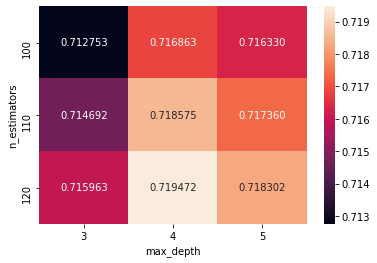

In [77]:
import seaborn as sns
cv_auc_values = pd.DataFrame({'max_depth':depth,
                              'n_estimators': no_of_est,
                              'auc': cv_auc})
cv_auc_values = cv_auc_values.pivot("n_estimators","max_depth", "auc")
sns.heatmap(cv_auc_values, annot=True, fmt="f")
plt.show()

In [78]:
results = results.sort_values(['rank_test_score'])
best_depth = int(results[results['rank_test_score'] == 1].param_max_depth)
best_n_estimators = int(results[results['rank_test_score'] == 1].param_n_estimators)
results.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
5,230.624216,0.996491,1.094910,0.011630,4,120,"{'max_depth': 4, 'n_estimators': 120}",0.718115,0.718722,0.732958,0.716990,0.710577,0.719472,0.007342,1,0.856510,0.857154,0.854931,0.855239,0.857838,0.856334,0.001108
4,214.412764,1.369309,1.105326,0.016504,4,110,"{'max_depth': 4, 'n_estimators': 110}",0.717557,0.718088,0.731831,0.716021,0.709382,0.718575,0.007322,2,0.850152,0.850225,0.847402,0.849552,0.851484,0.849763,0.001338


In [79]:
print('GBDT having depth {} and no of estimators(boosting stages) {} gives the best cross-validation auc value'.format(best_depth,best_n_estimators))

GBDT having depth 4 and no of estimators(boosting stages) 120 gives the best cross-validation auc value


From the above plot and table, we can observe that best hyper parameters are max_depth = 10 and n_estimators = 500 and we take these values for testing. 

#### 2.1.1 Testing

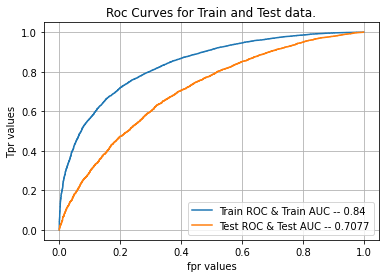

In [80]:
from sklearn.metrics import roc_curve,roc_auc_score,confusion_matrix

clf = xgb.XGBClassifier(max_depth = best_depth, n_estimators = best_n_estimators, booster = 'gbtree',objective = 'binary:logistic', learning_rate = 0.1,  n_jobs = -1, verbose = 2)
clf.fit(X_train_tfidf,Y_train)

y_prob_tr = clf.predict_proba(X_train_tfidf)[:,1]
fpr_tr, tpr_tr, thresholds_tr = roc_curve(Y_train,y_prob_tr)
plt.plot(fpr_tr, tpr_tr)

y_prob_te = clf.predict_proba(X_te_tfidf)[:,1]
fpr_te, tpr_te, thresholds_te = roc_curve(Y_te,y_prob_te)
plt.plot(fpr_te, tpr_te)

AUC_tr_tfidf = roc_auc_score(Y_train, y_prob_tr)
AUC_te_tfidf = roc_auc_score(Y_te, y_prob_te)

plt.grid()
plt.legend( ('Train ROC & Train AUC -- '+str(np.round(AUC_tr_tfidf, decimals=4)), 'Test ROC & Test AUC -- '+str(np.round(AUC_te_tfidf, decimals=4)) ) )
plt.xlabel('fpr values')
plt.ylabel('Tpr values')
plt.title('Roc Curves for Train and Test data.')
plt.show()


Confusion matrix for the Test data.


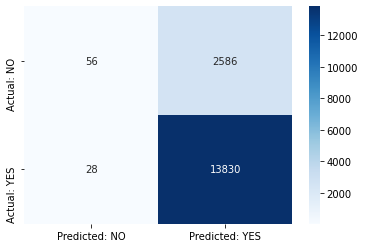

In [81]:
y_pred_tfidf=clf.predict(X_te_tfidf)
cnf_mtrx_tfidf = confusion_matrix(Y_te, y_pred_tfidf)

print('Confusion matrix for the Test data.')
#print(cnf_mtrx_tfidf)
x=pd.DataFrame(cnf_mtrx_tfidf, columns = ["Predicted: NO","Predicted: YES"], index = ["Actual: NO","Actual: YES"] )
sns.heatmap(x, annot=True,fmt="d", cmap='Blues')
plt.show()

### 2.2 Set2(TF-IDF Weighted W2V) Features dup

In [82]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

depth = [3, 4, 5] #, 6, 7]
no_of_est = [100, 110, 120] #, 130, 140, 150]
hyper_param = {'max_depth' : depth, 'n_estimators' : no_of_est }

clf = xgb.XGBClassifier(booster = 'gbtree',objective = 'binary:logistic', learning_rate = 0.1,  n_jobs = -1, verbose = 2)

classifier = GridSearchCV(clf, hyper_param, cv=5,return_train_score=True, scoring='roc_auc', n_jobs=-1)
classifier.fit(X_train_tfidf_w2v, Y_train)

results = pd.DataFrame.from_dict(classifier.cv_results_)

In [83]:
results = results.sort_values(['rank_test_score'])
results.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
8,208.193783,27.187026,1.374231,0.332773,5,120,"{'max_depth': 5, 'n_estimators': 120}",0.722501,0.722132,0.723046,0.704428,0.700469,0.714515,0.009936,1,0.919534,0.926608,0.927927,0.924328,0.927076,0.925095,0.003025
4,163.315378,0.197586,1.507982,0.022203,4,110,"{'max_depth': 4, 'n_estimators': 110}",0.717285,0.723287,0.726300,0.703116,0.701576,0.714313,0.010205,2,0.851048,0.855572,0.854882,0.851769,0.854765,0.853607,0.001830


In [84]:
train_auc= results['mean_train_score']
cv_auc = results['mean_test_score'] 
depth =  results['param_max_depth']
no_of_est = results['param_n_estimators']
# we need not generate mesh grid explicitly as depth and min_samples combined together form 2D points for which auc is available.
#print(depth)
#print(no_of_est)

In [85]:
enable_plotly_in_cell()

trace1 = go.Scatter3d(x=no_of_est,y=depth,z=train_auc, name = 'train')
trace2 = go.Scatter3d(x=no_of_est,y=depth,z=cv_auc, name = 'Cross validation')
data_to_plot = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='no_of_est'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data_to_plot, layout=layout)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

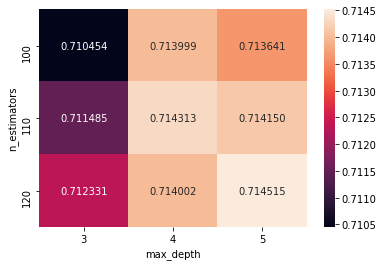

In [86]:
import seaborn as sns
cv_auc_values = pd.DataFrame({'max_depth':depth,
                              'n_estimators': no_of_est,
                              'auc': cv_auc})
cv_auc_values = cv_auc_values.pivot("n_estimators","max_depth", "auc")
sns.heatmap(cv_auc_values, annot=True, fmt="f")
plt.show()

In [87]:
results = results.sort_values(['rank_test_score'])
best_depth_tfidf_w2v = int(results[results['rank_test_score'] == 1].param_max_depth)
best_n_estimators_tfidf_w2v = int(results[results['rank_test_score'] == 1].param_n_estimators)
results.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
8,208.193783,27.187026,1.374231,0.332773,5,120,"{'max_depth': 5, 'n_estimators': 120}",0.722501,0.722132,0.723046,0.704428,0.700469,0.714515,0.009936,1,0.919534,0.926608,0.927927,0.924328,0.927076,0.925095,0.003025
4,163.315378,0.197586,1.507982,0.022203,4,110,"{'max_depth': 4, 'n_estimators': 110}",0.717285,0.723287,0.726300,0.703116,0.701576,0.714313,0.010205,2,0.851048,0.855572,0.854882,0.851769,0.854765,0.853607,0.001830


In [88]:
print('GBDT having depth {} and no of estimators(boosting stages) {} gives the best cross-validation auc value'.format(best_depth_tfidf_w2v,best_n_estimators_tfidf_w2v))

GBDT having depth 5 and no of estimators(boosting stages) 120 gives the best cross-validation auc value


#### 2.2.1 Testing

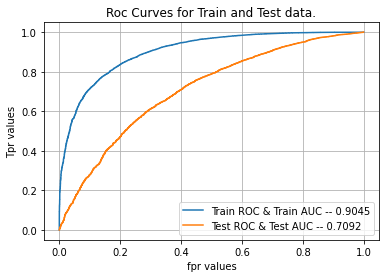

In [89]:
from sklearn.metrics import roc_curve,roc_auc_score,confusion_matrix

clf = xgb.XGBClassifier(max_depth = best_depth_tfidf_w2v, n_estimators = best_n_estimators_tfidf_w2v, booster = 'gbtree',objective = 'binary:logistic', learning_rate = 0.1,  n_jobs = -1, verbose = 2)
clf.fit(X_train_tfidf_w2v,Y_train)

y_prob_tr = clf.predict_proba(X_train_tfidf_w2v)[:,1]
fpr_tr, tpr_tr, thresholds_tr = roc_curve(Y_train,y_prob_tr)
plt.plot(fpr_tr, tpr_tr)

y_prob_te = clf.predict_proba(X_te_tfidf_w2v)[:,1]
fpr_te, tpr_te, thresholds_te = roc_curve(Y_te,y_prob_te)
plt.plot(fpr_te, tpr_te)

AUC_tr_tfidf_w2v = roc_auc_score(Y_train, y_prob_tr)
AUC_te_tfidf_w2v = roc_auc_score(Y_te, y_prob_te)

plt.grid()
plt.legend( ('Train ROC & Train AUC -- '+str(np.round(AUC_tr_tfidf_w2v, decimals=4)), 'Test ROC & Test AUC -- '+str(np.round(AUC_te_tfidf_w2v, decimals=4)) ) )
plt.xlabel('fpr values')
plt.ylabel('Tpr values')
plt.title('Roc Curves for Train and Test data.')
plt.show()


Confusion matrix for the Test data.


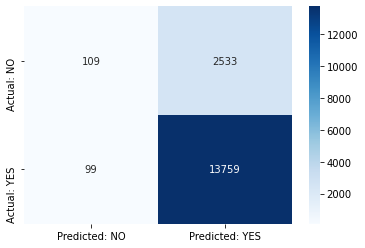

In [90]:
y_pred_tfidf_w2v=clf.predict(X_te_tfidf_w2v)
cnf_mtrx_tfidf_w2v = confusion_matrix(Y_te, y_pred_tfidf_w2v)

print('Confusion matrix for the Test data.')
#print(cnf_mtrx_tfidf)
x=pd.DataFrame(cnf_mtrx_tfidf_w2v, columns = ["Predicted: NO","Predicted: YES"], index = ["Actual: NO","Actual: YES"] )
sns.heatmap(x, annot=True,fmt="d", cmap='Blues')
plt.show()

# 3. Summary

In [91]:
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Vectorizer","Model", "Hyper parameters (depth and no of estimators)", "Train AUC", "Test AUC"]

for i in range(1):
    x.add_row(['TFIDF', "GBDT", (best_depth,best_n_estimators) , np.round(AUC_tr_tfidf,4), np.round(AUC_te_tfidf,4) ])
    x.add_row(["TFIDF-W2V", "GBDT" , (best_depth_tfidf_w2v,best_n_estimators_tfidf_w2v) , np.round(AUC_tr_tfidf_w2v,4) , np.round(AUC_te_tfidf_w2v,4) ])
print(x)

+------------+-------+-----------------------------------------------+-----------+----------+
| Vectorizer | Model | Hyper parameters (depth and no of estimators) | Train AUC | Test AUC |
+------------+-------+-----------------------------------------------+-----------+----------+
|   TFIDF    |  GBDT |                    (4, 120)                   |    0.84   |  0.7077  |
| TFIDF-W2V  |  GBDT |                    (5, 120)                   |   0.9045  |  0.7092  |
+------------+-------+-----------------------------------------------+-----------+----------+
